#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [4]:
# %%time
# # Import Configuration file
# i = pybna.Importer(config="config.yaml")
# # Import Study Area boundary shape file
# i.import_boundary('City_of_Davis_Boundary.shp', overwrite=True)
# # Mention the State fips, for California it is 6
# i.import_census_blocks(fips=6, overwrite=True)
# i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

In [5]:
# %%time
# i.import_osm_network(overwrite=True)

In [6]:
# %%time
# # stress
# s = pybna.Stress(config='config.yaml')
# s.segment_stress()
# s.crossing_stress()

In [7]:
# Read the LTS shape file
lts=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/share with alex s/share with alex s/comprehensive_data_set.shp")
lts['length']=lts.length
lts.head()

fid_  road_id   osm_functi  osm_ft_lan  osm_tf_lan  osm_speed osm_tf_bik  \
0     0       15         None           0           0          0       None   
1     0      844  residential           0           0          0       None   
2     0    57338  residential           0           0          0       None   
3     0     5423    secondary           3           0          0       None   
4     0     7139  residential           0           0          0       None   

  osm_ft_bik osm_oneway     city  ... exist_lts_  exist_lts1  planned_lt  \
0       None       None  hayward  ...          3           3           0   
1       None       None  hayward  ...          1           1           1   
2       None       None  hayward  ...          1           1           1   
3       None       None  hayward  ...          4           4           4   
4       None       None  hayward  ...          1           1           1   

   planned__1 lts_tomap_ lts_tomap1  geom_Lengt exist_lt_1  \
0           0          3          0  283.833562          3   
1           1          1          0   34.070050          1   
2           1          1          0    2.615091          1   
3           4          4          0    3.068993          4   
4           1          1          0   61.315594          1   

                                            geometry      length  
0  LINESTRING (585796.274 4168917.387, 585815.157...  283.833562  
1  LINESTRING (585376.499 4167063.203, 585408.746...   34.070050  
2  LINESTRING (582375.868 4165538.720, 582377.162...    2.615091  
3  LINESTRING (578387.624 4165593.723, 578389.963...    3.068993  
4  LINESTRING (577068.837 4164506.246, 577072.821...   61.315594  

[5 rows x 34 columns]

In [8]:
lts.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [9]:
#lts=lts0.to_crs('EPSG:26910')
#lts.head()

# Lets calculate the slope for each link

In [10]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

In [11]:
# Open the raster image
barea_slope = rasterio.open('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Slope/Slope/cslope11.img')
print(barea_slope.crs)
#rioplot.show(barea_slope)

EPSG:4269


In [12]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -104, 'mean': -3.891794414661842, 'max': 1784}


In [13]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

fid_  road_id   osm_functi  osm_ft_lan  osm_tf_lan  osm_speed osm_tf_bik  \
0     0       15         None           0           0          0       None   
1     0      844  residential           0           0          0       None   
2     0    57338  residential           0           0          0       None   
3     0     5423    secondary           3           0          0       None   
4     0     7139  residential           0           0          0       None   
5     0     9497  residential           0           0          0    sharrow   
6     0   452928         None           0           0          0       None   
7     0    56226  residential           0           0          0       None   
8     0    31861  residential           0           0          0       None   
9     0    33556  residential           0           0          0       None   

  osm_ft_bik osm_oneway     city  ... exist_lts_  exist_lts1  planned_lt  \
0       None       None  hayward  ...          3           3           0   
1       None       None  hayward  ...          1           1           1   
2       None       None  hayward  ...          1           1           1   
3       None       None  hayward  ...          4           4           4   
4       None       None  hayward  ...          1           1           1   
5    sharrow       None  hayward  ...          3           3           3   
6       None       None  hayward  ...          3           3           0   
7       None       None  hayward  ...          1           1           1   
8       None       None  hayward  ...          1           1           1   
9       None       None  hayward  ...          1           1           1   

   planned__1 lts_tomap_ lts_tomap1  geom_Lengt exist_lt_1  \
0           0          3          0  283.833562          3   
1           1          1          0   34.070050          1   
2           1          1          0    2.615091          1   
3           4          4          0    3.068993          4   
4           1          1          0   61.315594          1   
5           3          3          0   43.498009          3   
6           0          3          0  184.093268          3   
7           1          1          0    2.174155          1   
8           1          1          0    2.603041          1   
9           1          1          0    1.536087          1   

                                            geometry      length  
0  LINESTRING (-122.02723 37.66343, -122.02702 37...  283.833562  
1  LINESTRING (-122.03221 37.64675, -122.03185 37...   34.070050  
2  LINESTRING (-122.06639 37.63329, -122.06638 37...    2.615091  
3  LINESTRING (-122.11158 37.63413, -122.11155 37...    3.068993  
4  LINESTRING (-122.12664 37.62444, -122.12659 37...   61.315594  
5  LINESTRING (-122.08311 37.66445, -122.08267 37...   43.498009  
6  LINESTRING (-122.03585 37.60597, -122.03593 37...  184.093268  
7  LINESTRING (-122.08323 37.61448, -122.08321 37...    2.174155  
8  LINESTRING (-122.12347 37.63329, -122.12350 37...    2.603041  
9  LINESTRING (-122.12445 37.64633, -122.12446 37...    1.536087  

[10 rows x 34 columns]

In [14]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot:>

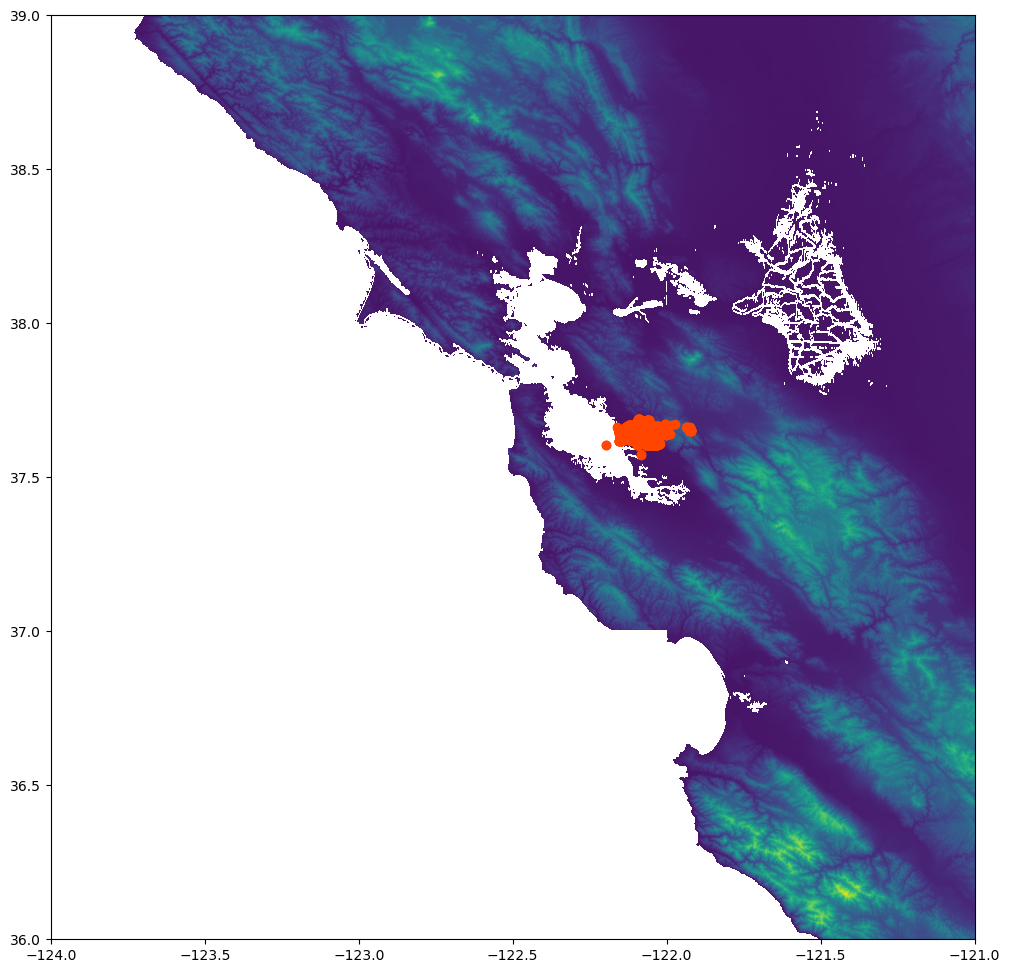

In [15]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [17]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["road_id","starting point"]]
sf1.columns=["road_id","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["road_id","geometry","start_lon","start_lat"]]
sf2.head(5)

road_id                                        geometry   start_lon  \
0       15   POINT (-122.02723413773181 37.66342523924798) -122.027234   
1      844   POINT (-122.03220993188853 37.64675419972342) -122.032210   
2    57338  POINT (-122.06639148391989 37.633289325304354) -122.066391   
3     5423    POINT (-122.1115812714389 37.63413409482137) -122.111581   
4     7139   POINT (-122.12664104937484 37.62444489289135) -122.126641   

   start_lat  
0  37.663425  
1  37.646754  
2  37.633289  
3  37.634134  
4  37.624445

In [18]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [19]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["road_id","ending point"]]
ef1.columns=["road_id","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["road_id","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 188 ms
Wall time: 187 ms


road_id                                       geometry     end_lon  \
0       15  POINT (-122.02586241719034 37.66127720734803) -122.025862   
1      844  POINT (-122.0318457325202 37.646652099534194) -122.031846   
2    57338  POINT (-122.0663770844215 37.633268725287515) -122.066377   
3     5423  POINT (-122.11155497132684 37.63411599470061) -122.111555   
4     7139  POINT (-122.1265894489374 37.624995994307156) -122.126589   

     end_lat  
0  37.661277  
1  37.646652  
2  37.633269  
3  37.634116  
4  37.624996

In [20]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 3.14 s
Wall time: 3.14 s


In [21]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['road_id'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['road_id'], keep='first')
barea_all1.head()

CPU times: total: 78.1 ms
Wall time: 66.6 ms


road_id                                      geometry_x   start_lon  \
0       15   POINT (-122.02723413773181 37.66342523924798) -122.027234   
1      844   POINT (-122.03220993188853 37.64675419972342) -122.032210   
2    57338  POINT (-122.06639148391989 37.633289325304354) -122.066391   
3     5423    POINT (-122.1115812714389 37.63413409482137) -122.111581   
4     7139   POINT (-122.12664104937484 37.62444489289135) -122.126641   

   start_lat  starting_ele                                     geometry_y  \
0  37.663425           321  POINT (-122.02586241719034 37.66127720734803)   
1  37.646754           207  POINT (-122.0318457325202 37.646652099534194)   
2  37.633289             7  POINT (-122.0663770844215 37.633268725287515)   
3  37.634134             8  POINT (-122.11155497132684 37.63411599470061)   
4  37.624445             4  POINT (-122.1265894489374 37.624995994307156)   

      end_lon    end_lat  ending_ele  fid_  ... planned__1  lts_tomap_  \
0 -122.025862  37.661277         316     0  ...          0           3   
1 -122.031846  37.646652         212     0  ...          1           1   
2 -122.066377  37.633269           7     0  ...          1           1   
3 -122.111555  37.634116           8     0  ...          4           4   
4 -122.126589  37.624996           4     0  ...          1           1   

   lts_tomap1  geom_Lengt exist_lt_1  \
0           0  283.833562          3   
1           0   34.070050          1   
2           0    2.615091          1   
3           0    3.068993          4   
4           0   61.315594          1   

                                            geometry      length  \
0  LINESTRING (-122.02723 37.66343, -122.02702 37...  283.833562   
1  LINESTRING (-122.03221 37.64675, -122.03185 37...   34.070050   
2  LINESTRING (-122.06639 37.63329, -122.06638 37...    2.615091   
3  LINESTRING (-122.11158 37.63413, -122.11155 37...    3.068993   
4  LINESTRING (-122.12664 37.62444, -122.12659 37...   61.315594   

                                   starting point  \
0   POINT (-122.02723413773181 37.66342523924798)   
1   POINT (-122.03220993188853 37.64675419972342)   
2  POINT (-122.06639148391989 37.633289325304354)   
3    POINT (-122.1115812714389 37.63413409482137)   
4   POINT (-122.12664104937484 37.62444489289135)   

                                    ending point      slope  
0  POINT (-122.02586241719034 37.66127720734803)   1.761596  
1  POINT (-122.0318457325202 37.646652099534194)  14.675646  
2  POINT (-122.0663770844215 37.633268725287515)   0.000000  
3  POINT (-122.11155497132684 37.63411599470061)   0.000000  
4  POINT (-122.1265894489374 37.624995994307156)   0.000000  

[5 rows x 45 columns]

<AxesSubplot:>

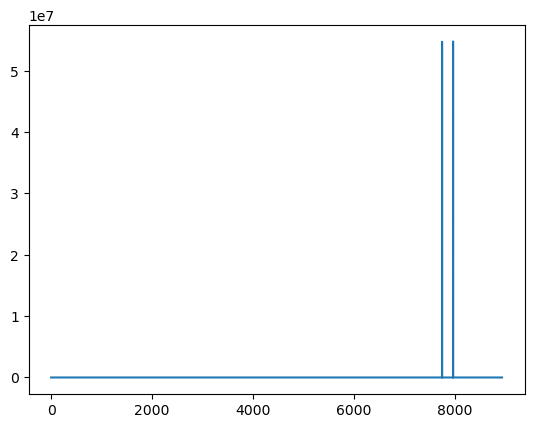

In [22]:
barea_all1.slope.plot()

In [24]:
# write a slope impedance function
def slope_correction(length,FT_SEG_STR,slope):
    if slope <=2:
        return length*(1+FT_SEG_STR)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+FT_SEG_STR)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+FT_SEG_STR)
    else:
        return length*(1+3.20+FT_SEG_STR)

In [25]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['exist_lts1']=pd.to_numeric(barea_all1['exist_lts1']).astype(int)
barea_all1['exist_lts1'].dtypes

dtype('int32')

In [26]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['exist_lts1'],row['slope']),axis=1)
barea_all1.head(8)

road_id                                      geometry_x   start_lon  \
0       15   POINT (-122.02723413773181 37.66342523924798) -122.027234   
1      844   POINT (-122.03220993188853 37.64675419972342) -122.032210   
2    57338  POINT (-122.06639148391989 37.633289325304354) -122.066391   
3     5423    POINT (-122.1115812714389 37.63413409482137) -122.111581   
4     7139   POINT (-122.12664104937484 37.62444489289135) -122.126641   
5     9497   POINT (-122.08311267797055 37.66444652000258) -122.083113   
6   452928   POINT (-122.03585145429392 37.60597286651636) -122.035851   
7    56226   POINT (-122.08323048207328 37.61447890828318) -122.083230   

   start_lat  starting_ele                                     geometry_y  \
0  37.663425           321  POINT (-122.02586241719034 37.66127720734803)   
1  37.646754           207  POINT (-122.0318457325202 37.646652099534194)   
2  37.633289             7  POINT (-122.0663770844215 37.633268725287515)   
3  37.634134             8  POINT (-122.11155497132684 37.63411599470061)   
4  37.624445             4  POINT (-122.1265894489374 37.624995994307156)   
5  37.664447            29  POINT (-122.0826669796406 37.664278718823454)   
6  37.605973            19  POINT (-122.03790799933434 37.60595767153385)   
7  37.614479             3  POINT (-122.08320588132217 37.61447790772797)   

      end_lon    end_lat  ending_ele  fid_  ... lts_tomap_  lts_tomap1  \
0 -122.025862  37.661277         316     0  ...          3           0   
1 -122.031846  37.646652         212     0  ...          1           0   
2 -122.066377  37.633269           7     0  ...          1           0   
3 -122.111555  37.634116           8     0  ...          4           0   
4 -122.126589  37.624996           4     0  ...          1           0   
5 -122.082667  37.664279          29     0  ...          3           0   
6 -122.037908  37.605958          18     0  ...          3           0   
7 -122.083206  37.614478           3     0  ...          1           0   

   geom_Lengt  exist_lt_1                                           geometry  \
0  283.833562           3  LINESTRING (-122.02723 37.66343, -122.02702 37...   
1   34.070050           1  LINESTRING (-122.03221 37.64675, -122.03185 37...   
2    2.615091           1  LINESTRING (-122.06639 37.63329, -122.06638 37...   
3    3.068993           4  LINESTRING (-122.11158 37.63413, -122.11155 37...   
4   61.315594           1  LINESTRING (-122.12664 37.62444, -122.12659 37...   
5   43.498009           3  LINESTRING (-122.08311 37.66445, -122.08267 37...   
6  184.093268           3  LINESTRING (-122.03585 37.60597, -122.03593 37...   
7    2.174155           1  LINESTRING (-122.08323 37.61448, -122.08321 37...   

       length                                  starting point  \
0  283.833562   POINT (-122.02723413773181 37.66342523924798)   
1   34.070050   POINT (-122.03220993188853 37.64675419972342)   
2    2.615091  POINT (-122.06639148391989 37.633289325304354)   
3    3.068993    POINT (-122.1115812714389 37.63413409482137)   
4   61.315594   POINT (-122.12664104937484 37.62444489289135)   
5   43.498009   POINT (-122.08311267797055 37.66444652000258)   
6  184.093268   POINT (-122.03585145429392 37.60597286651636)   
7    2.174155   POINT (-122.08323048207328 37.61447890828318)   

                                    ending point      slope  impedance_of_link  
0  POINT (-122.02586241719034 37.66127720734803)   1.761596        1135.334248  
1  POINT (-122.0318457325202 37.646652099534194)  14.675646         177.164258  
2  POINT (-122.0663770844215 37.633268725287515)   0.000000           5.230181  
3  POINT (-122.11155497132684 37.63411599470061)   0.000000          15.344965  
4  POINT (-122.1265894489374 37.624995994307156)   0.000000         122.631188  
5  POINT (-122.0826669796406 37.664278718823454)   0.000000         173.992035  
6  POINT (-122.03790799933434 37.60595767153385)   0.543203         736.373071  
7  POINT (-122.08320

### Lets Calculate the Connectivity

## Helper Function

In [27]:
def sf_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()


    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total motor path
    sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

    #connectivity score
    sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
    connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [28]:
def graph_parameter(sf_motor_network,cul_de_sacs,convex_hull_area1,sf_area):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    # Calculate the number of Intersections
    crossroad_nodes = [node for node in sf_lts_motor_g1.nodes() if len(sf_lts_motor_g1.edges(node)) > 2]
    # Number of intersections where edge>2
    NI=get_number_of_elements(crossroad_nodes)
    # Calculate the parameters that we need
    edge_length_total1=sf_lts_motor_g.geometry.length.sum()
    street_segment_count1=sf_lts_motor_g1.number_of_edges()
    n1=sf_lts_motor_g1.number_of_nodes()
    sn=nx.number_connected_components(sf_lts_motor_g1)
#    cul_de_sacs=1102 # used cul-de-scas function from ArcGIS Pro
    
    Street_density=(edge_length_total1*0.000621371)/(convex_hull_area1*3.861e-7) # mile/square mile
    Intersection_density=(NI/convex_hull_area1*3.861e-7) # per mile square
    Street_density_by_land_area=(edge_length_total1*0.000621371)/(sf_area) # mile/square mile
    Intersection_density_by_land_area=(NI/sf_area) # per mile square
    CNR=(NI/(NI+cul_de_sacs))
    alpha=(street_segment_count1-n1+sn)/(2*n1-5)
    beta=street_segment_count1/n1
    gamma=street_segment_count1/(3*n1-2)
    eta=edge_length_total1/street_segment_count1
    GTP=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)
    Cyclomatic_Number=street_segment_count1-n1+1
    Aggregate_TP_score=alpha+beta+gamma+Cyclomatic_Number
    
    connectivity_score.append((NI,street_segment_count1,n1,sn,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,Cyclomatic_Number,Aggregate_TP_score))
    cols=['Number of Intersection','street_segment_count','Number of Node','Number of subnetwork','Street_density','Intersection_density','Street_density_by_land_area','Intersection_density_by_land_area','CNR','alpha','beta','gamma','eta','GTP','cyclomatic_Number','Aggregate_TP_score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result

In [29]:
def grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network):
    
    connectivity_score=[]

    for index, row in input_census_tract.iterrows():
        network_motor=gpd.clip(sf_motor_network,row['geometry'])
        sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
        sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
        # Calculate the total motor path
        sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()



        network_bike=gpd.clip(sf_bike_network,row['geometry'])
        sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
        sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
        # Calculate the total motor path
        sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

        #connectivity score
        sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
        connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [30]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

## Connectivity

In [31]:
# Bring US Census track
census_track=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID    NAME  \
0  G0100010020100      01      001  020100  01001020100     201   
1  G0100010020200      01      001  020200  01001020200     202   
2  G0100010020300      01      001  020300  01001020300     203   
3  G0100010020400      01      001  020400  01001020400     204   
4  G0100010020501      01      001  020501  01001020501  205.01   

              NAMELSAD  MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT  \
0     Census Tract 201  G5020        S  9825304.0  28435.0  +32.4819731   
1     Census Tract 202  G5020        S  3320818.0   5669.0  +32.4757580   
2     Census Tract 203  G5020        S  5349271.0   9054.0  +32.4740243   
3     Census Tract 204  G5020        S  6384282.0   8408.0  +32.4710304   
4  Census Tract 205.01  G5020        S  6203654.0      0.0  +32.4478607   

       INTPTLON    Shape_Leng    Shape_Area  \
0  -086.4915648  16217.763443  9.853735e+06   
1  -086.4724678   9824.372415  3.326483e+06   
2  -086.4597033  10519.641206  5.358327e+06   
3  -086.4448353  12521.196228  6.392683e+06   
4  -086.4225578  11422.446991  6.203654e+06   

                                            geometry  
0  POLYGON ((3516926.098 77059.002, 3516963.104 7...  
1  POLYGON ((3519482.809 73938.168, 3519490.446 7...  
2  POLYGON ((3521117.478 74718.075, 3521099.105 7...  
3  POLYGON ((3521674.809 77662.170, 3521681.008 7...  
4  POLYGON ((3525078.936 76191.813, 3525244.092 7...

In [32]:
# read the Hayward boundary shape file
study_bd=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/data/COH_Jurisdictions.shp")
study_bd

NAME NAME_SHORT POLITICAL_ NAME_ONLY  \
0  City of Hayward       None       None      None   

                                            geometry  
0  POLYGON ((6101644.000 2077601.000, 6101638.000...

<AxesSubplot:>

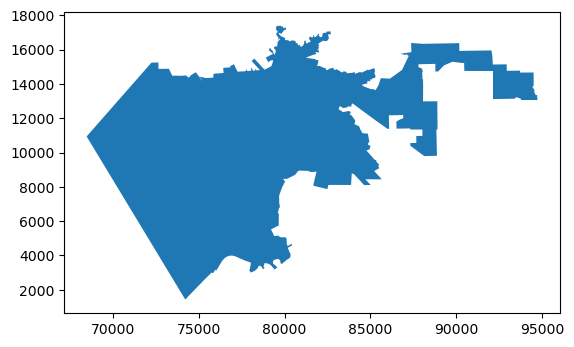

In [33]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [34]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
4480  G0600010441503      06      001  441503  06001441503  4415.03   
4467  G0600010440332      06      001  440332  06001440332  4403.32   
4466  G0600010440331      06      001  440331  06001440331  4403.31   
4460  G0600010440301      06      001  440301  06001440301  4403.01   
4468  G0600010440333      06      001  440333  06001440333  4403.33   

                  NAMELSAD  MTFCC FUNCSTAT       ALAND      AWATER  \
4480  Census Tract 4415.03  G5020        S  72745500.0  12525279.0   
4467  Census Tract 4403.32  G5020        S   2297853.0         0.0   
4466  Census Tract 4403.31  G5020        S   1761655.0         0.0   
4460  Census Tract 4403.01  G5020        S   4329374.0         0.0   
4468  Census Tract 4403.33  G5020        S   2505503.0         0.0   

         INTPTLAT      INTPTLON     Shape_Leng    Shape_Area  \
4480  +37.4899766  -121.9742068  103457.981851  7.299653e+07   
4467  +37.5828284  -122.0858891    9132.828879  2.297856e+06   
4466  +37.5980622  -122.0829553    6734.568436  1.761655e+06   
4460  +37.6012643  -122.0427413   11995.865886  4.329375e+06   
4468  +37.6053298  -122.0738277    6953.455415  2.505502e+06   

                                               geometry  
4480  MULTIPOLYGON (((77091.640 3959.938, 77082.247 ...  
4467  MULTIPOLYGON (((80274.013 4500.050, 80278.224 ...  
4466  MULTIPOLYGON (((79630.220 6669.121, 79630.178 ...  
4460  MULTIPOLYGON (((84706.414 8438.053, 84706.833 ...  
4468  MULTIPOLYGON (((81485.014 8891.584, 81497.287 ...

In [64]:
census_track2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/Hayward_City_cnesus_Tract.shp")

In [37]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

NAME NAME_SHORT POLITICAL_ NAME_ONLY  \
0  City of Hayward       None       None      None   

                                            geometry       area  
0  POLYGON ((79760.338 17397.355, 79758.808 17382...  64.505348

In [38]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    64.505348
dtype: float64

In [39]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

road_id                                      geometry_x   start_lon  \
0       15   POINT (-122.02723413773181 37.66342523924798) -122.027234   
1      844   POINT (-122.03220993188853 37.64675419972342) -122.032210   
2    57338  POINT (-122.06639148391989 37.633289325304354) -122.066391   
3     5423    POINT (-122.1115812714389 37.63413409482137) -122.111581   
4     7139   POINT (-122.12664104937484 37.62444489289135) -122.126641   

   start_lat  starting_ele                                     geometry_y  \
0  37.663425           321  POINT (-122.02586241719034 37.66127720734803)   
1  37.646754           207  POINT (-122.0318457325202 37.646652099534194)   
2  37.633289             7  POINT (-122.0663770844215 37.633268725287515)   
3  37.634134             8  POINT (-122.11155497132684 37.63411599470061)   
4  37.624445             4  POINT (-122.1265894489374 37.624995994307156)   

      end_lon    end_lat  ending_ele  fid_  ... lts_tomap_  lts_tomap1  \
0 -122.025862  37.661277         316     0  ...          3           0   
1 -122.031846  37.646652         212     0  ...          1           0   
2 -122.066377  37.633269           7     0  ...          1           0   
3 -122.111555  37.634116           8     0  ...          4           0   
4 -122.126589  37.624996           4     0  ...          1           0   

   geom_Lengt  exist_lt_1                                           geometry  \
0  283.833562           3  LINESTRING (85301.981 14475.008, 85320.740 144...   
1   34.070050           1  LINESTRING (84871.192 12622.697, 84903.384 126...   
2    2.615091           1  LINESTRING (81860.669 11115.330, 81861.949 111...   
3    3.068993           4  LINESTRING (77871.469 11193.745, 77873.797 111...   
4   61.315594           1  LINESTRING (76545.878 10113.646, 76550.222 101...   

       length                                  starting point  \
0  283.833562   POINT (-122.02723413773181 37.66342523924798)   
1   34.070050   POINT (-122.03220993188853 37.64675419972342)   
2    2.615091  POINT (-122.06639148391989 37.633289325304354)   
3    3.068993    POINT (-122.1115812714389 37.63413409482137)   
4   61.315594   POINT (-122.12664104937484 37.62444489289135)   

                                    ending point      slope  impedance_of_link  
0  POINT (-122.02586241719034 37.66127720734803)   1.761596        1135.334248  
1  POINT (-122.0318457325202 37.646652099534194)  14.675646         177.164258  
2  POINT (-122.0663770844215 37.633268725287515)   0.000000           5.230181  
3  POINT (-122.11155497132684 37.63411599470061)   0.000000          15.344965  
4  POINT (-122.1265894489374 37.624995994307156)   0.000000         122.631188  

[5 rows x 46 columns]

In [40]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

road_id                                      geometry_x   start_lon  \
758     29949  POINT (-122.08468375094148 37.573745168638034) -122.084684   
8789   341845    POINT (-122.08423568767502 37.6103998001538) -122.084236   
8106   232345   POINT (-122.08399354185667 37.61028851070051) -122.083994   
7146   304440    POINT (-122.0845827853063 37.61094730245381) -122.084583   
6530   420937   POINT (-122.08409358765421 37.61045499999182) -122.084094   

      start_lat  starting_ele                                      geometry_y  \
758   37.573745             2    POINT (-122.08315034275466 37.5752921034496)   
8789  37.610400             4  POINT (-122.08412606904528 37.610222417196894)   
8106  37.610289             4   POINT (-122.08409358765421 37.61045499999182)   
7146  37.610947             4    POINT (-122.08423568767502 37.6103998001538)   
6530  37.610455             4   POINT (-122.08479198298402 37.61159640365748)   

         end_lon    end_lat  ending_ele  fid_  ... lts_tomap_  lts_tomap1  \
758  -122.083150  37.575292           3     0  ...          1           0   
8789 -122.084126  37.610222           4     0  ...          1           0   
8106 -122.084094  37.610455           4     0  ...          3           0   
7146 -122.084236  37.610400           4     0  ...          1           0   
6530 -122.084792  37.611596           4     0  ...          3           0   

      geom_Lengt  exist_lt_1  \
758   257.191771           1   
8789   21.931053           1   
8106   20.474802           3   
7146   68.035764           1   
6530  140.848994           3   

                                               geometry      length  \
758   LINESTRING (80271.739 4500.060, 80264.820 4520...  257.191771   
8789  LINESTRING (80295.477 8568.516, 80305.232 8548...   21.931053   
8106  LINESTRING (80316.905 8556.247, 80308.000 8574...   20.474802   
7146  LINESTRING (80264.593 8629.164, 80295.477 8568...   68.035764   
6530  LINESTRING (80308.000 8574.692, 80245.841 8701...  140.848994   

                                      starting point  \
758   POINT (-122.08468375094148 37.573745168638034)   
8789    POINT (-122.08423568767502 37.6103998001538)   
8106   POINT (-122.08399354185667 37.61028851070051)   
7146    POINT (-122.0845827853063 37.61094730245381)   
6530   POINT (-122.08409358765421 37.61045499999182)   

                                        ending point     slope  \
758     POINT (-122.08315034275466 37.5752921034496)  0.388815   
8789  POINT (-122.08412606904528 37.610222417196894)  0.000000   
8106   POINT (-122.08409358765421 37.61045499999182)  0.000000   
7146    POINT (-122.08423568767502 37.6103998001538)  0.000000   
6530   POINT (-122.08479198298402 37.61159640365748)  0.000000   

      impedance_of_link  
758          514.383541  
8789          43.862106  
8106          81.899209  
7146         136.071528  
6530         563.395976  

[5 rows x 46 columns]

In [41]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


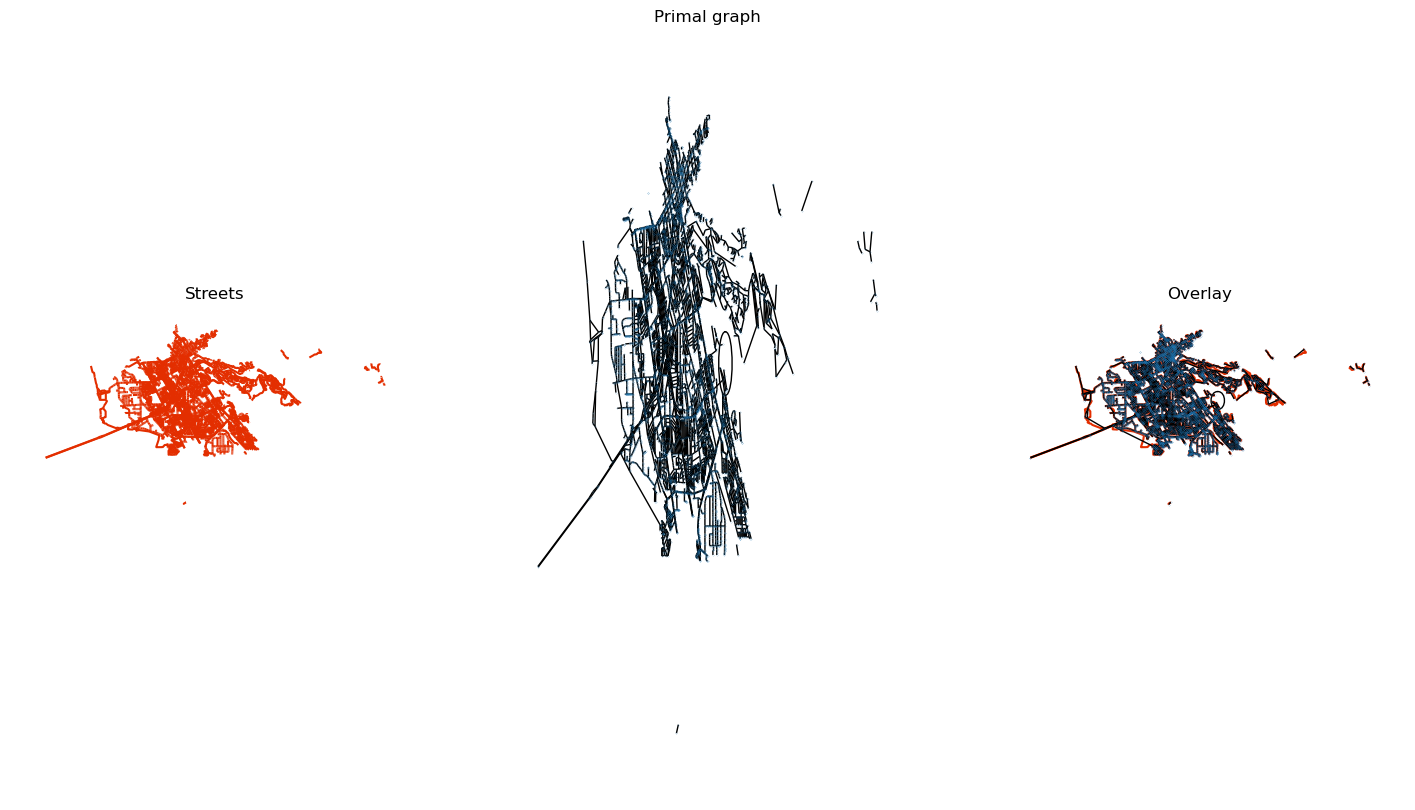

In [42]:
  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
  sf_lts.plot(color='#e32e00', ax=ax[0])
  for i, facet in enumerate(ax):
      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
      facet.axis("off")
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot:>

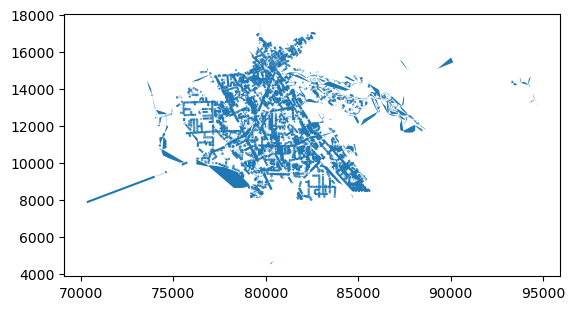

In [43]:
sf_lts['geometry'].convex_hull.plot()

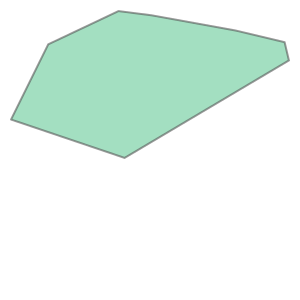

In [44]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot:>

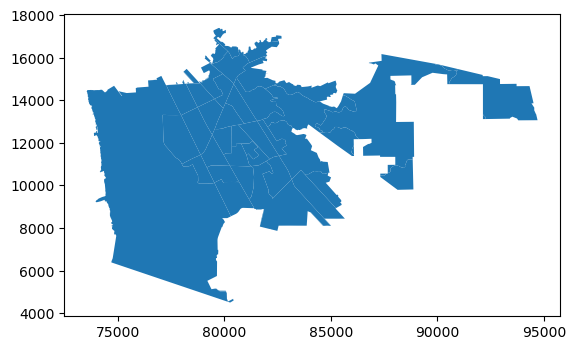

In [45]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [46]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

187656367.75340217

In [47]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [48]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [49]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

2725

# Bicycle Vs Motor Network Connectivity

<AxesSubplot:>

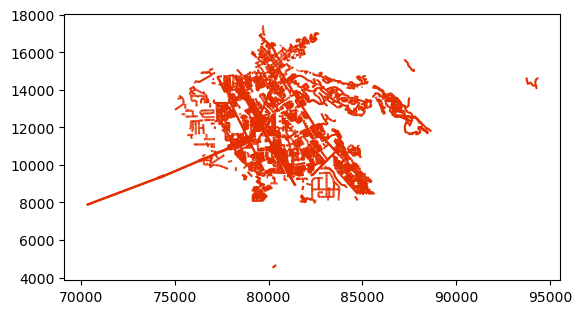

In [73]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['en_bike_ex']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

In [74]:
sf_motor_network.groupby(['exist_lts1'])['exist_lts1'].count()

exist_lts1
0       3
1    4460
2     164
3     731
4    1137
Name: exist_lts1, dtype: int64

<AxesSubplot:>

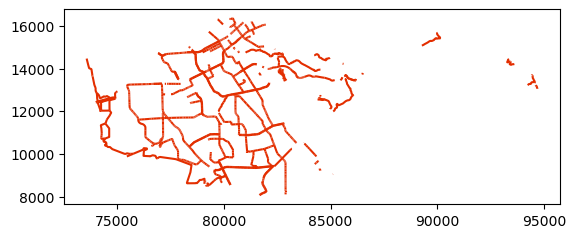

In [75]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['en_bike_ex']!='0']
sf_bike_network.plot(color='#e32e00')

In [76]:
sf_bike_network.groupby(['exist_lts1'])['exist_lts1'].count()

exist_lts1
1    274
2    743
3    556
4    689
Name: exist_lts1, dtype: int64

In [93]:
sf_bike_network.shape

(2262, 46)

In [77]:
input_census_tract=census_track2.reset_index()
input_census_tract.shape

(51, 17)

In [78]:
## Calculate the connectivity score for bike vs motor network condition
sf_connectivity_score (sf_motor_network,sf_bike_network)

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


motor_path_weighted_length  bike_path_weighted_length  Connectivity score
0                2.661065e+11               1.000577e+11            0.376006

In [79]:
SF_CS=grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network)
cs_census_track=pd.merge(SF_CS, input_census_tract, left_index=True, right_index=True)
cs_census_track.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Cu

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.Ge

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.Ge

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.Ge

motor_path_weighted_length  bike_path_weighted_length  Connectivity score  \
0                    0.000000                   0.000000                 NaN   
1                 1028.767083                   0.000000             0.00000   
2                    0.000000                   0.000000                 NaN   
3                 2337.143993                   0.000000             0.00000   
4                 8084.068562                4648.822175             0.57506   

   index         GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
0   4480  G0600010441503      06      001  441503  06001441503  4415.03   
1   4467  G0600010440332      06      001  440332  06001440332  4403.32   
2   4466  G0600010440331      06      001  440331  06001440331  4403.31   
3   4460  G0600010440301      06      001  440301  06001440301  4403.01   
4   4468  G0600010440333      06      001  440333  06001440333  4403.33   

               NAMELSAD  MTFCC FUNCSTAT       ALAND      AWATER     INTPTLAT  \
0  Census Tract 4415.03  G5020        S  72745500.0  12525279.0  +37.4899766   
1  Census Tract 4403.32  G5020        S   2297853.0         0.0  +37.5828284   
2  Census Tract 4403.31  G5020        S   1761655.0         0.0  +37.5980622   
3  Census Tract 4403.01  G5020        S   4329374.0         0.0  +37.6012643   
4  Census Tract 4403.33  G5020        S   2505503.0         0.0  +37.6053298   

       INTPTLON     Shape_Leng    Shape_Area  \
0  -121.9742068  103457.981851  7.299653e+07   
1  -122.0858891    9132.828879  2.297856e+06   
2  -122.0829553    6734.568436  1.761655e+06   
3  -122.0427413   11995.865886  4.329375e+06   
4  -122.0738277    6953.455415  2.505502e+06   

                                            geometry  
0  MULTIPOLYGON (((77091.640 3959.938, 77082.247 ...  
1  MULTIPOLYGON (((80274.013 4500.050, 80278.224 ...  
2  MULTIPOLYGON (((79630.220 6669.121, 79630.178 ...  
3  MULTIPOLYGON (((84706.414 8438.053, 84706.833 ...  
4  MULTIPOLYGON (((81485.014 8891.584, 81497.287 ...

In [80]:
cs_census_track['Connectivity score'].median()

0.10080035893548242

In [81]:
cs_census_track['Connectivity score'].mean()

1.8631621054387517

In [82]:
crs = {'init': 'epsg:7131'}
gdf = gpd.GeoDataFrame(cs_census_track, crs=crs, geometry = 'geometry')
gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/Hayward_City_B_vs_Motor_CS.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\1030171591.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/Hayward_City_B_vs_Motor_CS.shp")


In [83]:
gdf ['cs_ranking']=gdf .apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf.head()

motor_path_weighted_length  bike_path_weighted_length  Connectivity score  \
0                    0.000000                   0.000000                 NaN   
1                 1028.767083                   0.000000             0.00000   
2                    0.000000                   0.000000                 NaN   
3                 2337.143993                   0.000000             0.00000   
4                 8084.068562                4648.822175             0.57506   

   index         GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  ...  \
0   4480  G0600010441503      06      001  441503  06001441503  4415.03  ...   
1   4467  G0600010440332      06      001  440332  06001440332  4403.32  ...   
2   4466  G0600010440331      06      001  440331  06001440331  4403.31  ...   
3   4460  G0600010440301      06      001  440301  06001440301  4403.01  ...   
4   4468  G0600010440333      06      001  440333  06001440333  4403.33  ...   

   MTFCC FUNCSTAT       ALAND      AWATER     INTPTLAT      INTPTLON  \
0  G5020        S  72745500.0  12525279.0  +37.4899766  -121.9742068   
1  G5020        S   2297853.0         0.0  +37.5828284  -122.0858891   
2  G5020        S   1761655.0         0.0  +37.5980622  -122.0829553   
3  G5020        S   4329374.0         0.0  +37.6012643  -122.0427413   
4  G5020        S   2505503.0         0.0  +37.6053298  -122.0738277   

      Shape_Leng    Shape_Area  \
0  103457.981851  7.299653e+07   
1    9132.828879  2.297856e+06   
2    6734.568436  1.761655e+06   
3   11995.865886  4.329375e+06   
4    6953.455415  2.505502e+06   

                                            geometry        cs_ranking  
0  MULTIPOLYGON (((77091.640 3959.938, 77082.247 ...  poorly connected  
1  MULTIPOLYGON (((80274.013 4500.050, 80278.224 ...  poorly connected  
2  MULTIPOLYGON (((79630.220 6669.121, 79630.178 ...  poorly connected  
3  MULTIPOLYGON (((84706.414 8438.053, 84706.833 ...  poorly connected  
4  MULTIPOLYGON (((81485.014 8891.584, 81497.287 ...  fairly connected  

[5 rows x 21 columns]

In [84]:
# Now count the census tract for Bay area by cs ranking
gdf.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected     9
fairly connected          4
poorly connected         33
well connected            5
Name: GISJOIN, dtype: int64

# Consider high Stress Vs Low Stress connectivity: using Formula "Shortest Path(LTS1+LTS2)/Shortest Path in motor network

In [85]:
# Split the network as low VS high stress network to get the connectivity by stress level
sf_motor_network_op2=sf_motor_network
sf_bike_network_op2=sf_lts.loc[sf_lts['exist_lts1']<3]

In [86]:
sf_bike_network_op2.groupby(['exist_lts1'])['exist_lts1'].count()

exist_lts1
0       3
1    4734
2     907
Name: exist_lts1, dtype: int64

In [87]:
# low Vs High stress connectivity score
## Calculate the connectivity score for bike vs motor network condition
low_high_stress_CS=sf_connectivity_score (sf_motor_network_op2,sf_bike_network_op2)
low_high_stress_CS

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


motor_path_weighted_length  bike_path_weighted_length  Connectivity score
0                2.661065e+11               2.243866e+09            0.008432

In [88]:
# Calculate the census level stress for high vs low stress network
SF_CS_hl=grid_connectivity_score (input_census_tract,sf_bike_network_op2,sf_motor_network_op2)
SF_CS_hl.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Cu

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.Ge

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.Ge

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.Ge

motor_path_weighted_length  bike_path_weighted_length  Connectivity score
0                    0.000000                   0.000000                 NaN
1                 1028.767083                1028.767083                 1.0
2                    0.000000                   0.000000                 NaN
3                    0.000000                2337.143993                 inf
4                    0.000000                8084.068562                 inf

In [89]:
SF_CS_hl['Connectivity score'].median()

1.888281471656011

In [90]:
cs_census_track_hl=pd.merge(SF_CS_hl, input_census_tract, left_index=True, right_index=True)
crs = {'init': 'epsg:7131'}
gdf_hl = gpd.GeoDataFrame(cs_census_track_hl, crs=crs, geometry = 'geometry')
gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/Hayward_City_Census_track_level_CS_hl.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_7780\700021031.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/Hayward_City_Census_track_level_CS_hl.shp")


In [91]:
gdf_hl['cs_ranking']=gdf_hl.apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf_hl.head()

motor_path_weighted_length  bike_path_weighted_length  Connectivity score  \
0                    0.000000                   0.000000                 NaN   
1                 1028.767083                1028.767083                 1.0   
2                    0.000000                   0.000000                 NaN   
3                    0.000000                2337.143993                 inf   
4                    0.000000                8084.068562                 inf   

   index         GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  ...  \
0   4480  G0600010441503      06      001  441503  06001441503  4415.03  ...   
1   4467  G0600010440332      06      001  440332  06001440332  4403.32  ...   
2   4466  G0600010440331      06      001  440331  06001440331  4403.31  ...   
3   4460  G0600010440301      06      001  440301  06001440301  4403.01  ...   
4   4468  G0600010440333      06      001  440333  06001440333  4403.33  ...   

   MTFCC FUNCSTAT       ALAND      AWATER     INTPTLAT      INTPTLON  \
0  G5020        S  72745500.0  12525279.0  +37.4899766  -121.9742068   
1  G5020        S   2297853.0         0.0  +37.5828284  -122.0858891   
2  G5020        S   1761655.0         0.0  +37.5980622  -122.0829553   
3  G5020        S   4329374.0         0.0  +37.6012643  -122.0427413   
4  G5020        S   2505503.0         0.0  +37.6053298  -122.0738277   

      Shape_Leng    Shape_Area  \
0  103457.981851  7.299653e+07   
1    9132.828879  2.297856e+06   
2    6734.568436  1.761655e+06   
3   11995.865886  4.329375e+06   
4    6953.455415  2.505502e+06   

                                            geometry             cs_ranking  
0  MULTIPOLYGON (((77091.640 3959.938, 77082.247 ...       poorly connected  
1  MULTIPOLYGON (((80274.013 4500.050, 80278.224 ...  excellently connected  
2  MULTIPOLYGON (((79630.220 6669.121, 79630.178 ...       poorly connected  
3  MULTIPOLYGON (((84706.414 8438.053, 84706.833 ...  excellently connected  
4  MULTIPOLYGON (((81485.014 8891.584, 81497.287 ...  excellently connected  

[5 rows x 21 columns]

In [92]:
# Now count the census tract for Bay area by cs ranking
gdf_hl.groupby(['cs_ranking'])['cs_ranking'].count()

cs_ranking
excellently connected    34
fairly connected          3
poorly connected          8
well connected            6
Name: cs_ranking, dtype: int64

# End of coding